In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger
from datetime import datetime
import h5py

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action='ignore', message='RuntimeWarning: overflow encountered in multiply')

############ real running ##############

In [3]:
# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)

# os.chdir('F:/LANL/')
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num
# statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedpolfolder = '/processed_data/'+uniquefolder+'pulseadd_D/'
# # processedasymfolder = '/processed_data/'+uniquefolder+'asym_D/'
# # processedasymfolder_bg = '/processed_data/'+uniquefolder+'asym_bg_D/'
# polSavename = os.getcwd()+processedpolfolder+run_num+'_pulseadd_D'
# # AsymSavename = os.getcwd()+processedasymfolder+run_num+'_asym_D'
# # AsymSavename_bg = os.getcwd()+processedasymfolder_bg+run_num+'_asym_bg_D'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'pulseadd_D.txt', delay = False)

# if not os.path.exists(os.getcwd()+processedpolfolder):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedpolfolder)
#     print("Directory created successfully")
# else:
#     pass

############ test running ##############

In [4]:
run_num = '16410'
os.chdir('F:/LANL/')
datadir = 'sample_data/'
runs_folder = 'runs16410-16452/'
uniquefolder = 'debug_sample/'+runs_folder
# uniquefolder = 'La_sample/'
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num
SFNormFile = 'SF_Norm_files/'+runs_folder+run_num
# AsymSavename = '****testing testing testing'
ONOFFSavename = 'F:/LANL/testing_ONOFF'
AsymSavename = 'F:/LANL/testing_asyms'

########################################

In [5]:
# print(os.getcwd())

## cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed ##<br>
## chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all

chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream _D
# chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream _U

# print(os.getcwd() + folder)

start = time.time()
fullstart = time.time()

read_data = []
fileLength = []

def open_file():
    for el in chan_enab:
        # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

end = time.time()

print('file open time: ' + str(end-start))            

# print('saving processed data to ' + polSavename)
print("Channel is " + str(chan_enab))

file open time: 13.797083139419556
Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]


Store the big header for each channel in arrays

In [6]:
BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []

targetDict = {0: "La", 1: "Tb2O3", 2: "Yb2O3", 3: "Sm2O3", 4: "Er2O3", 5: "Ho2O3", 6: "other"}
foilDict = {0: "TBD", 1: "TBD", 2: "TBD", 3: "TBD", 4: "TBD", 5: "TBD", 6: "other"}

target=(read_data[0][5]&0x00F0)>>4
foil=read_data[0][5]&0x000F
targetFlag = read_data[0][5]>>8&1
foilFlag = read_data[0][5]>>9&1
spinFiltFlag = read_data[0][5]>>10&1
spinFlipFlag = read_data[0][5]>>11&1
shutterFlag = read_data[0][5]>>12&1
facilityTrigFlag = read_data[0][5]>>13&1

if targetFlag:
    target=targetDict[(read_data[0][5]&0x00F0)>>4]
else:
    target = "empty"
if foilFlag:
    foil=foilDict[read_data[0][5]&0x000F]
else:
    foil = "empty"
for i in range(0,len(chan_enab)):
    BoardID.append(read_data[i][9]>>8)
    recordLength.append(((read_data[i][9]&0x00FF)<<16)+read_data[i][8])
    numSamples.append(((read_data[i][11]&0x00FF)<<16)+read_data[i][10])
    eventCounter.append(read_data[i][6]+(read_data[i][7]<<16))
    BoardID.append(read_data[i][9]>>8)  
    decFactor.append(read_data[i][11]>>8)
    chanDec.append(read_data[i][13]>>8)
    postTrig.append(read_data[i][15]>>8)
    groupStart.append(((read_data[i][13]&0x00FF)<<16)+read_data[i][12])
    groupEnd.append(((read_data[i][15]&0x00FF)<<16)+read_data[i][14])
    
    timestamp.append(read_data[i][16]+(read_data[i][17]<<16)+(read_data[i][18]<<32)+(read_data[i][19]<<40))  
    sizeFirstEvent.append(read_data[i][0]+(read_data[i][1]<<16))
    TTT.append(read_data[i][2]+(read_data[i][3]<<16)+(read_data[i][4]<<32))
    
#     print("For channel " + str(chan_enab[i]) + ", BoardID is " + str(BoardID[i])
#           + "; record length is " + str(recordLength[i]) + "; num Samples is " 
#           + str(numSamples[i]) + "; event counter is " + str(eventCounter[i]) + "; dec factor is " + str(decFactor[i]) + "; chan dec is " 
#           + str(chanDec[i]) + "; postTrig is " + str(postTrig[i]) + "; group start is " + str(groupStart[i]) + "; group end is " + str(groupEnd[i])
#           + "; epoch time is " + str(timestamp[i]) +  "; first event size is " + str(sizeFirstEvent[i]) + "; and ETTT is " + str(TTT[i]) + "\n")

BoardID = np.asarray(BoardID) 
recordLength = np.asarray(recordLength)
numSamples = np.asarray(numSamples)
eventCounter = np.asarray(eventCounter)
decFactor = np.asarray(decFactor)
chanDec = np.asarray(chanDec)
postTrig = np.asarray(postTrig)
groupStart = np.asarray(groupStart)
groupEnd = np.asarray(groupEnd)
timestamp = np.asarray(timestamp)
sizeFirstEvent = np.asarray(sizeFirstEvent)
TTT = np.asarray(TTT)

print("Target is " + target)
print("Foil is " + foil)
print("Shutter is open: " + str(bool(shutterFlag)))
print("Facility t0 is on: " + str(bool(facilityTrigFlag)))
print("Spin flipper is on: " + str(bool(spinFlipFlag)))
print("Spin filter is on: " + str(bool(spinFiltFlag)))
print("Target is present: " + str(bool(targetFlag)))
print("Foil is present: " + str(bool(foilFlag)))

Target is empty
Foil is empty
Shutter is open: False
Facility t0 is on: False
Spin flipper is on: True
Spin filter is on: True
Target is present: False
Foil is present: False


In[3]:

Determine the time axis for each channel

In [7]:
preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

np.asarray(preTime)
np.asarray(startTime)
np.asarray(endTime)
np.asarray(resolution)

xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

In[4]:

In [8]:
start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

start=time.time()
# ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))

dataread from binary time: 3.783689498901367


In [9]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)

In [10]:
## Load in SF and He normalization information ##
###########
SFNormFile_testing = 'F:/LANL/SF_Norm_files/runs13605-13735/13617.h5' ## change sf norm file here or use default
###########
try:
#     df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
    df_SF = pd.read_hdf(SFNormFile_testing, key='df_0')
#     df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')
    df_HE = pd.read_hdf(SFNormFile_testing, key='df_1')
except Exception as e:
    logger.error('run '+run_num + ' failed during SFNormFile load')
    logger.exception(e)

SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T

He_Norm_arr = df_HE[['pulse', 'norms','puckval']].to_numpy().T

if shutterFlag == 0:
    print('Shutter closed. NormFactor set to 1')
    NormFactor = 1
if shutterFlag == 1:
    NormFactor = 1000000 ## He integrals are huge, this normalizes all of those by a constant value for ease of use

HeNorms= (He_Norm_arr[1])/NormFactor

print(SF_Sort_arr)
print(He_Norm_arr[1]/NormFactor)

Shutter closed. NormFactor set to 1
[[2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5
  6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1
  2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0 1 2 3 4 5
  6 7 0]
 [23 68 113 158 203 248 293 338 383 428 473 518 563 608 653 698 743 788
  833 878 923 968 1013 1058 1103 1148 1193 1238 1283 1328 1373 1418 1463
  1508 1553 1598 1643 1688 1733 1778 1823 1868 1913 1958 2003 2048 2093
  2138 2183 2228 2273 2318 2363 2408 2453 2498 2543 2588 2633 2678 2723
  2768 2813 2858 2903 2948 2993 3038 3083 3128 3173 3218 3263 3308 3353
  3398 3443 3488 3533 3578 3623 3668 3713 3758 3803 3848 3893 3938 3983
  4028 4073 4118 4163 4208 4253 4298 4343 4388 4433 4478 4523 4568 4613
  4658 4703 4748 4793 4838 4883 4928 4973]]
[5128485.10555458 5375942.30555513 5299235.92428559 ... 6091810.06015786
 6554292.06952324 6407941.21587357]


In [11]:
print(He_Norm_arr)

[[0.00000000e+00 1.00000000e+00 2.00000000e+00 ... 4.99700000e+03
  4.99800000e+03 4.99900000e+03]
 [5.12848511e+06 5.37594231e+06 5.29923592e+06 ... 6.09181006e+06
  6.55429207e+06 6.40794122e+06]
 [2.04200000e+03 2.04200000e+03 2.04200000e+03 ... 3.44300000e+03
  3.44300000e+03 3.44300000e+03]]


In [13]:
print(He_Norm_arr[2])

[2042. 2042. 2042. ... 3443. 3443. 3443.]


[2042. 2042. 2042. ... 3443. 3443. 3443.]
(array([1963, 1964, 1965, ..., 4997, 4998, 4999], dtype=int64),)


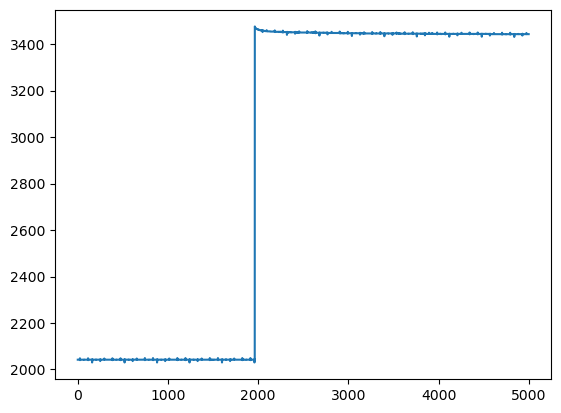

In [12]:
print(He_Norm_arr[2])
puck_thresh = 2500
print(np.where(He_Norm_arr[2]>=puck_thresh))  ## 2500 is overkill but it works. Hardcode
plt.plot(He_Norm_arr[2])
puck_in = np.where(He_Norm_arr[2]>=puck_thresh)

In [22]:
plt.plot(ys_arr[5][3])

In[7]:

basesub and plotting ##

In [23]:
start = time.time()
%matplotlib qt
baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])  ##70% before the trigger
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
legend =  ['NaI', 'R']

s = 1961 ## pulse to look at
t=s+4

##  dont know why this is so slow ##

def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
#             plt.legend()
            
# plotter(ys_arr[-1:], xs[-1:], baseR, numSamples) 

In [24]:
@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

@njit ## jit is faster for large # channels, slower for small # channels
def basesub_norm(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
        tempys_basesub[pulse]=tempys_basesub[pulse]/HeNorms[pulse] 
    return tempys_basesub

ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
# ys_basesub_norm = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)
# for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
#     ys_basesub[i] = basesub_norm(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using
# ys_basesub_norm[-1] = ys_basesub_norm[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

plotting and/or base subtraction time: 3.784733295440674


use 6Li t0 for all instead of for themselves individually ##

In [39]:
start = time.time()

NaIthresh=2000
Li6thresh=400
threshold_array = (np.full(len(ys_basesub), NaIthresh))
threshold_array[-1] = Li6thresh

# njit ## numba does not support reversed, but this could be changed if it's slow

def find_offset(ys, thresharr):
    xCrosses = np.zeros((len(ys), numRuns)) #outer array is crossing arrays for given channel, inner array is crossing for each event
    offset = np.zeros((len(ys), numRuns), dtype=np.int32) ##offset in bins for each channel, each pulse
    modeCrosses = np.zeros((len(ys)), dtype=np.float64)
    for i in reversed(range(len(ys))):
        #xValues.append([])
        for p in range(len(ys[i])):
            xing = np.argmax(ys[i][p] > thresharr[i])
            #print(xing)
            xCrosses[i][p] = xing
        modeCrosses[i] = (st.mode(xCrosses[i])) #find the most typical crossing value for each channel
        for p in range(len(xCrosses[i])):
            offset[i][p] = (modeCrosses[-1] - xCrosses[i][p]) ## make sure this is the correct sign!!! 
    if (np.all(xCrosses[-1])) == False:
        emessage = ('ERROR: 6Li threshold was not reached for at least one pulse')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    return offset, xCrosses, modeCrosses

if shutterFlag == 0:
    print('Shutter closed. No t0 offsets')
    offset = np.zeros((len(ys_basesub), numRuns), dtype=np.int32)
if shutterFlag == 1:
    NormFactor = 1000000 ## He integrals are huge, this normalizes all of those by a constant value for ease of use
    offset, xCrosses, modeCrosses = find_offset(ys_basesub, threshold_array)
# offset, xCrosses, modeCrosses = find_offset(ys_basesub, threshold_array)

end = time.time()
# print('finding offset time: ' + str(end-start))  

Shutter closed. No t0 offsets


In[9]:

extend all arrays by a value, check that the max number of offset on 6Li is less than that value ##

In [41]:
start = time.time()

extendedRange = 3 ## must be a positive value which to extend ys_arr
if abs(max(offset[-1], key = abs)) > extendedRange: ## if the max offset of 6Li is >extendedRange, something is wrong
    emessage = ('ERROR: largest offset greater than extended range')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

try:
    ys_ext = np.zeros((len(ys_basesub), len(ys_basesub[0]), len(ys_basesub[0][0])+extendedRange*2), dtype=np.float64)
    ys_cut = np.zeros((len(ys_basesub), len(ys_basesub[0]), (len(ys_ext[0][0])-((extendedRange*2)+1)*2)))
    xs_cut = np.zeros((len(ys_cut), len(ys_cut[0][0])))
except Exception as e:
    logger.error('run '+run_num + ' failed during ys_cut array creation')
    logger.exception(e)

# cant use jit because np.pad is not supported ##

def align_cut(ys, xs_arr, extendedr):
    tempys_ext = np.zeros((len(ys), len(ys[0])+extendedr*2), dtype=np.float64)
    tempys_cut = np.zeros((len(ys), (len(tempys_ext[0])-((extendedr*2)+1)*2)))
    tempxs_cut = np.zeros(len(tempys_cut[0]))
    for p in range(len(ys)):
        tempys_ext[p] = np.pad(ys[p], extendedr, 'constant', constant_values=(0))
        tempys_ext[p] = np.roll(tempys_ext[p],offset[-1][p]) ## assumes 6Li at -1 position
        tempys_cut[p] = tempys_ext[p][((extendedr*2)+1):-((extendedr*2)+1)].copy() ## cut by 7 (if extRange == 3)
        tempys_cut[p] = tempys_cut[p]/HeNorms[p] ## normalize by 3He integral  ## comment out if using basesub_norm
    x_cut_amt = int((len(ys[0]) - len(tempys_cut[0]))/2)
    tempxs_cut = xs_arr[x_cut_amt:-x_cut_amt].copy()
    return tempys_cut, tempxs_cut

# looping every channel through function is 5x faster ##

try:
    for i in range(len(ys_basesub)):
        ys_cut[i], xs_cut[i] = align_cut(ys_basesub[i], xs[i], extendedRange)
except Exception as e:
    logger.error('run '+run_num + ' failed aligning and cutting')
    logger.exception(e)
    
# checkp = 2053
# print(offset[-1][checkp]) ## checking offset for one example checkpulse
# print('original index for checkpulse: '+str(np.argmax(ys_basesub[0][checkp]> 2000))) ## we can follow the index as it changes with extension/cut
# #print('extended range index for checkpulse: '+str(np.argmax(ys_ext[0][checkp]> 2000)))
# print('cut array index for checkpulse: '+str(np.argmax((ys_cut[0][checkp]*HeNorms[checkp])> 2000)))

del ys_ext ## might help with memory issues
del ys_basesub

end = time.time()
print('aligning and cutting time: ' + str(end-start))            

2025-04-10 22:44:06.088 | ERROR    | __main__:<module>:14 - run 16410 failed during ys_cut array creation
2025-04-10 22:44:06.100 | ERROR    | __main__:<module>:15 - name 'ys_basesub' is not defined
Traceback (most recent call last):

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x00000165CEFD43A0, file "C:\Users\gabeo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x00000165CF1CF040>

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <modu

2025-04-10 22:44:06.287 | ERROR    | __main__:<module>:38 - run 16410 failed aligning and cutting
2025-04-10 22:44:06.287 | ERROR    | __main__:<module>:39 - name 'ys_basesub' is not defined
Traceback (most recent call last):

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x00000165CEFD43A0, file "C:\Users\gabeo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x00000165CF1CF040>

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <module> at 0

NameError: name 'ys_ext' is not defined

begin SF organization ##

In [34]:
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0: ## catches state switches at pulse 0
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+45) >= 5000: ## breaks for state switches at pulse 0
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset so sequences are 1-14 instead of 2-15
                break
            seq = seq+1 ## otherwise continue regular sorting
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

In [35]:
def find_leftover(SFsort_info, seq_arr): ## in case we want to use the other 6 states left over
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

###################### SF organization commented out for pol ########################

In [36]:
print('skipped SF organization')

skipped SF organization


In[12]<br>
try:<br>
    sequence = organize_SF(SF_Sort_arr)<br>
    if len(sequence[0]) == 14: ## catches state switches at pulse 0, leftovers are at the end of the regular sequence<br>
        leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]<br>
        for i in range(len(sequence)):<br>
            sequence[i].pop(-1) ## deletes the leftovers sequence for state switches at pulse 0<br>
    else:<br>
        leftovers = find_leftover(SF_Sort_arr, sequence) ## otherwise can use normal function<br>
except Exception as e:<br>
    logger.error('run '+run_num + ' failed during sequencing')<br>
    logger.exception(e)

print(str(len(sequence[0]))+' sequences with sequence order: '+str(sequence[1][0]))<br>
print(leftovers)

 add up pulses for their respective state, in each 8 step sequence ##<br>
 turning into a by-channel function 06.13.24 ##

start = time.time()<br>
sequence = np.asarray(sequence, dtype = object)

ON_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON<br>
OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF

@njit<br>
def add_pulse(ys, SFarr):<br>
    temp_ON = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)<br>
    temp_OFF = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)<br>
    for seq in range(0, len(SFarr[0])): ## for every sequence<br>
    #         print('seq:' +str(SFarr[0][seq]))<br>
#         print('seq:' +str(seq))<br>
        for state in range(0, len(SFarr[1][0])): ## for every state in the sequence<br>
    #         print("states loop " + str(range(0, len(SFarr[1][0]))[0]) + ' - ' +  str(range(0, len(SFarr[1][0]))[-1]))<br>
            s = SFarr[1][seq][state] ## try this to condense code. Basically, the state currently at<br>
            if s==0 or s==3 or s==5 or s==6: ## these are ON states<br>
#                 print('ON "s" state '+str(s))<br>
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))<br>
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +<br>
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')<br>
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum<br>
                    temp_ON[seq] = np.add(temp_ON[seq],ys[p]) ## start with zeros, add to each iteratively<br>
            if s==1 or s==2 or s==4 or s==7: ## these are OFF states<br>
#                 print('OFF "s" state '+str(s))<br>
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))<br>
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +<br>
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')<br>
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])):<br>
                    temp_OFF[seq] = np.add(temp_OFF[seq],ys[p])<br>
    return temp_ON, temp_OFF

####################################################################################<br>
In[13]

In [37]:
start = time.time()
## new pulse add for polarization attempt ##

ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
added_pulses = np.zeros((len(ys_cut), len(ys_cut[0][0])), dtype=np.float64)  ## channels, 8992 data points each

@njit
def add_pulse_noSF(ys):
    pulses_sum  = np.zeros((len(ys[0])), dtype=np.float64)
    for p in range(0, len(ys)):
        # print('pulse ',p)
        pulses_sum = np.add(pulses_sum,ys[p])
    return pulses_sum

for i in range(len(ys_cut)):
    # print('#################### channel: ' + str(i) + ' ##########################')
    added_pulses[i] = add_pulse_noSF(ys_cut[i])

end = time.time()
print('summing pulses time: ' + str(end-start))  

summing pulses time: 1.3438658714294434


In [38]:
## testing ####
for i in range(0, len(added_pulses)):
    plt.plot(xs_cut[0], added_pulses[i], label = 'chan ' + str(chan_enab[i]))
plt.legend()
plt.show()

###################### Don't need BG/Voigt fitting here (?), and no asymm ########################

In[15]:<br>
bg fitting

from scipy import odr<br>
from scipy.special import voigt_profile<br>
from scipy.optimize import curve_fit

bg_region1_beg = 4180<br>
bg_region1_end = 5450<br>
bg_region2_beg = 6250<br>
bg_region2_end = 8992<br>
bg_reg1 = [bg_region1_beg,bg_region1_end]<br>
bg_reg2 = [bg_region2_beg,bg_region2_end]<br>
fullrange = bg_reg2[1]-bg_reg1[0]

# In[18]:

## change to 2nd order poly in cleaned up version<br>
start = time.time()

def bg_fitsubtract(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit<br>
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region<br>
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)<br>
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)<br>
    x = np.append(x1,x2)<br>
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region<br>
    ys_bgsub = []<br>
    for seq in range(0, len(ys)): ## number of sequences, usually 13<br>
        fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]<br>
        fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]<br>
        datasplice = np.append(fitdata1, fitdata2)<br>
        y = datasplice<br>
        data = odr.Data(x, y)<br>
        poly_model2 = odr.polynomial(2)  # using third order polynomial model<br>
        odr_obj = odr.ODR(data, poly_model2)<br>
        output = odr_obj.run()  # running ODR fitting<br>
        poly2 = np.poly1d(output.beta[::-1])<br>
        poly_y2 = poly2(x)<br>
        fullpoly_y2 = poly2(fullx)<br>
        bgsubtracted = ys[seq][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit<br>
        ys_bgsub.append(bgsubtracted)<br>
    return ys_bgsub

## background subtraction currently only for NaI detectors<br>
num_fittingchs = len(ON_sums)-1  ## removes the Li detector, assumes it is there<br>
ON_bgsub = np.zeros((num_fittingchs,len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction<br>
OFF_bgsub = np.zeros((num_fittingchs,len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

for i in range(0, len(ON_sums)-1):<br>
    if chan_enab[i] == 24:<br>
        emessage = ('bg_ fit does not work for 6Li yet')<br>
        logger.error('run '+run_num + emessage)<br>
        raise Exception(emessage)<br>
    ON_bgsub[i]  = bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i])<br>
    OFF_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[i])

# end = time.time()<br>
# print('bg_ fitting time: ' + str(end-start))  

# In[19]:<br>
# now voigt

def voigt2(x, sig, gam, xshift, amp):<br>
    fit = voigt_profile(x-xshift, sig, gam)*amp<br>
    return fit

# In[21]:

# res_region_beg = 5450<br>
# res_region_end = 6250<br>
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region<br>
res_region_end = bg_region2_beg<br>
res_reg = [res_region_beg,res_region_end]<br>
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:<br>
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')<br>
    logger.error('run '+run_num + emessage)<br>
    raise Exception(emessage)

xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array

# In[22]:

# resonance region is assumed to be in between 2 background regions. Could maybe change this. 11.22.24<br>
# start = time.time()

In [ ]:
 
# def voigt_fitting(bef_res_reg, aft_res_reg,xs,ys):
#     fit_curves = []
#     parameters = []
#     for seq in range(0, len(ys)): ## number of sequences, usually 13
#         ydata = ys[seq][bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
#         popt, pcov = curve_fit(voigt2, xs, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
#         fitted_curve = voigt2(xs, popt[0],popt[1],popt[2],popt[3],) ## sigma, gamma, xshift (res. center), amp. related thing
#         fit_curves.append(fitted_curve)
#         fit_params = popt
#         fit_errs = np.diagonal(pcov)
#         parameters.append([fit_params,fit_errs])
#     return fit_curves, parameters

res_size = res_reg[1]-res_reg[0] <br>
ON_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## channels, sequences, range of V_ subtraction<br>
OFF_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## channels, sequences, range of V_ subtraction

ON_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]<br>
OFF_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64)

for i in range(0, len(ON_sums)-1): <br>
    if chan_enab[i] == 24:<br>
        emessage = ('bg_ fit does not work for 6Li yet')<br>
        logger.error('run '+run_num + emessage)<br>
        raise Exception(emessage)<br>
    try:<br>
        ON_vfit[i], ON_vfit_params[i]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub[i])<br>
        OFF_vfit[i], OFF_vfit_params[i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[i])<br>
    except Exception as e:<br>
        logger.error('run '+run_num + ' failed during Voigt fitting')<br>
        logger.exception(e)

end = time.time()<br>
print('bg_ fitting time: ' + str(end-start)) 

 In[23]:<br>
sum up all pulses, and then calculate asymmetry using "amplitude"

start = time.time()<br>
all_ONOFF = np.zeros((len(ON_sums),2, len(ON_sums[0][0])), dtype=np.float64) ## all summed ON[0] and OFF[1] pulses for each channel, not each sequence

def all_onoff(ON_arr, OFF_arr):<br>
    tempallON = np.zeros((len(ON_arr[0])), dtype=np.float64)<br>
    tempallOFF = np.zeros((len(ON_arr[0])), dtype=np.float64)<br>
    for seq in range(0, len(ON_arr)): ## number of sequences<br>
        tempallON = np.add(ON_arr[seq],tempallON)<br>
        tempallOFF = np.add(OFF_arr[seq],tempallOFF)<br>
    return tempallON, tempallOFF

for i in range(len(ON_sums)):<br>
    all_ONOFF[i][0], all_ONOFF[i][1] = all_onoff(ON_sums[i], OFF_sums[i]) ## channel, ON[0] or OFF[1], summed wave

 In[25]:

all_Vfitcurve_ON = np.zeros((len(ON_vfit), len(ON_vfit[0][0])), dtype=np.float64) ## all summed ON or OFF pulses for each channel, not each sequence<br>
all_Vfitcurve_OFF = np.zeros((len(ON_vfit), len(ON_vfit[0][0])), dtype=np.float64) ## all summed ON or OFF pulses for each channel, not each sequence

def all_vfits(vfit_arrs):<br>
    tempall_vfits = np.zeros((len(vfit_arrs[0])), dtype=np.float64)<br>
    for seq in range(0, len(vfit_arrs)): ## number of sequences<br>
        tempall_vfits = np.add(vfit_arrs[seq],tempall_vfits)<br>
    return tempall_vfits

for i in range(len(ON_vfit)):<br>
    all_Vfitcurve_ON[i]  = all_vfits(ON_vfit[i]) ## all added vfits for each channel<br>
    all_Vfitcurve_OFF[i] = all_vfits(OFF_vfit[i]) 

# In[26]:

## add and avg all sigma/gamma/xloc for ON and OFF per channel. Should not be dpendent on spin state.<br>
sig_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 sigma +/- error for each channel<br>
gam_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 gamma +/- error for each channel<br>
xloc_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 xlocation +/- error for each channel

def sum_param(ON_params_arr, OFF_params_arr, key):  ## key choose between sigma gamma or xloc<br>
    if key != 'sigma' and key != 'gamma' and key != 'xloc':<br>
        emessage = ('not a valid Voigt fit parameter to sum')<br>
        logger.error('run '+run_num + emessage)<br>
        raise Exception(emessage)<br>
    if key == 'sigma':<br>
        param = 0<br>
    if key == 'gamma':<br>
        param = 1<br>
    if key == 'xloc':<br>
        param = 2<br>
    tempsum = 0<br>
    temperr  = []<br>
    for seq in range(0, len(ON_params_arr)): ## number of sequences<br>
        seqsum = (ON_params_arr[seq][0][param]+OFF_params_arr[seq][0][param])/2  # "normalize" with /2 but not for #sequences<br>
        ## [0] above corresponds to the real values of the paramters, as opposed to their errors<br>
        ON_err = ON_params_arr[seq][1][param]<br>
        OFF_err = OFF_params_arr[seq][1][param]<br>
        ## above [1] is used which corresponds to the error in "parameter"<br>
        ON_deriv  =  1  ## left over from asym error to keep error prop consistent<br>
        OFF_deriv =  1<br>
        ## use err prop to get below<br>
        seq_err = np.sqrt((ON_deriv**2)*(ON_err**2)+(OFF_deriv**2)*(OFF_err**2))/2<br>
        temperr.append(seq_err) ## collect all errors for each sequence<br>
        tempsum = np.add(seqsum,tempsum)<br>
    ## add error or each sequence in quad.<br>
    toterr = np.sqrt(sum([i**2 for i in temperr]))  ## use list comprehension for sum of squares<br>
    out = [tempsum,toterr]<br>
    return out

for i in range(len(ON_vfit)):<br>
    sig_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='sigma')<br>
    gam_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='gamma') <br>
    xloc_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='xloc') 

# In[27]:

## new asym using "amplitude" parameter, with error prop<br>
asym_ch_err = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)

def asym3_err(ON_params_arr, OFF_params_arr):<br>
    tempasym = 0<br>
    temperr  = []<br>
    for seq in range(0, len(ON_params_arr)): ## number of sequences<br>
        A_plus = ON_params_arr[seq][0][-1] ## just makes things cleaner<br>
        A_min  = OFF_params_arr[seq][0][-1]<br>
        ## [0] corresponds to the real values of the paramters, as opposed to their errors. [-1] is the "amplitude"<br>
        seqasym = ((A_plus-A_min) / (A_plus+A_min))<br>
        ON_err = ON_params_arr[seq][1][-1]<br>
        OFF_err = OFF_params_arr[seq][1][-1]<br>
        ## above [1] is used which corresponds to the error in "amplitude"<br>
        ON_deriv  =  2*A_min/ ((A_plus+A_min)**2)<br>
        OFF_deriv = -2*A_plus/((A_plus+A_min)**2)<br>
        ## use err prop to get below<br>
        seq_err = np.sqrt((ON_deriv**2)*(ON_err**2)+(OFF_deriv**2)*(OFF_err**2))<br>
#         seq_err = (1/(A_plus+A_min**2))*np.sqrt(4*(A_min**2)(ON_err)**2+4*(A_plus**2)(OFF_err)**2) ## alternate form<br>
        temperr.append(seq_err) ## collect all errors for each sequence<br>
        tempasym = np.add(seqasym,tempasym)<br>
#         print(temperr)<br>
    ## add error or each sequence asym in quad.<br>
    toterr = np.sqrt(sum([i**2 for i in temperr]))  ## use list comprehension for sum of squares<br>
    out = [tempasym,toterr]<br>
    return out  ## don't normalize asymON_vfit_params this time...

for i in range(len(ON_vfit)):<br>
    asym_ch_err[i] = asym3_err(ON_vfit_params[i], OFF_vfit_params[i]) ## error is really high...

In [ ]:
    
# end = time.time()
# print('calc asym, add pulses/fit params: ' + str(end-start))    

In[28]:<br>
save summed pulses to be analyzed for polarization

 new version adds vfit curves

In [ ]:
######## new addition of puck state ch. 29 04.10.25 ########

In [77]:
print(np.mean(He_Norm_arr[2]))
print(puck_in)
print(puck_in_pulses)

2895.3756
1
(array([1963, 1964, 1965, ..., 4997, 4998, 4999], dtype=int64),)


In [76]:
puck_thresh = 2500

if np.mean(He_Norm_arr[2])==0: ## catches runs with no ch. 29. 0/1 for True/False key
    puck_in = -1  ## to differentiate from the other 2 true/false states, because these don't have any information, but the puck could have been in
    puck_in_pulses = ['No ch.29 or no puck information'] ## need to keep track of what runs don't have a ch.29. Puck was in, but with no ch29 to tell.
else:
    puck_in_pulses = np.where(He_Norm_arr[2]>=puck_thresh) ## empty array for runs w/out puck
    if len(puck_in_pulses) == 0: ## puck_in state is false for empty array
        puck_in = 0
    else:
        puck_in = 1 ## if any pulse crosses threshold. Could be that the very last or first pulse has the puck in...
print((puck_in_pulses))

(array([1963, 1964, 1965, ..., 4997, 4998, 4999], dtype=int64),)


In [ ]:
############################################################

In [79]:
testing_savename_addpulse = 'F:/LANL/'+'testing_puckstate'+'ONOFF'
testing_savename_asyms = 'F:/LANL/'+'testing_puckstate'+'asyms'

In [82]:
start = time.time()

# with h5py.File(polSavename+'.h5', 'w') as hdf5_file:
with h5py.File(testing_savename_addpulse+'.h5', 'w') as hdf5_file:
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['puck_state'] = puck_in ## adding the puck information
    hdf5_file.attrs['puck_pulses'] = puck_in_pulses ## will be empty if puck is not in (usually)
    # hdf5_file.attrs['sequences'] = len(sequence[0])
    for i in range(0,len(ys_cut)):
        Ch_grp = hdf5_file.create_group('ch_'+str(np.char.zfill(str(chan_enab[i]), 2)))
        added_pulses_subgrp = Ch_grp.create_group('added_pulses')
        # added_vfits_subgrp = Ch_grp.create_group('added_vfits')
        # added_pulses_subgrp.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
        added_pulses_subgrp.create_dataset('ch_'+str(np.char.zfill(str(chan_enab[i]), 2)), data=added_pulses[i])
        # if chan_enab[i] == 24:
        #     pass
        # else:
        #     added_vfits_subgrp.attrs['resonance_region'] = res_reg
        #     added_vfits_subgrp.attrs['note'] = 'added all Voigt fits for each ON or OFF state, per ch.'
        #     added_vfits_subgrp.create_dataset('Vfit_curve_ON',data=all_Vfitcurve_ON[i])
        #     added_vfits_subgrp.create_dataset('Vfit_curve_OFF',data=all_Vfitcurve_OFF[i])
        
# end = time.time()
# print('saving hdf5: ' + str(end-start))    

In [ ]:
start = time.time()
# AsymSavename_raw = AsymSavename
# with h5py.File(AsymSavename+'.h5', 'w') as hdf5_file:
with h5py.File(testing_savename_asyms+'.h5', 'w') as hdf5_file:
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['sequences'] = len(sequence[0])
    hdf5_file.attrs['puck_state'] = puck_in ## adding the puck information
    hdf5_file.attrs['puck_pulses'] = puck_in_pulses ## will be empty if puck is not in (usually)
    for i in range(0,len(asym_ch_err)): ## change this to length of asymms!
        Ch_grp = hdf5_file.create_group('ch_'+str(np.char.zfill(str(chan_enab[i]), 2)))
        Ch_grp.attrs['quick asym'] = asym_ch_err[i]
        Ch_grp.attrs['avg_xloc']  = xloc_ch[i]
        Ch_grp.attrs['avg_sigma'] = sig_ch[i]
        Ch_grp.attrs['avg_gamma'] = gam_ch[i]
        ON_subgrp = Ch_grp.create_group('ON')
        OFF_subgrp = Ch_grp.create_group('OFF')
        ON_subgrp.attrs['for_each_sequence'] = ['parameter (sigma, gamma, x_loc, "amplitude")', 'and its error']
        OFF_subgrp.attrs['for_each_sequence'] = ['parameter (sigma, gamma, x_loc, "amplitude")', 'and its error']
        ON_subgrp.create_dataset('parameters',data=ON_vfit_params[i])
        OFF_subgrp.create_dataset('parameters',data=OFF_vfit_params[i])
        ON_subgrp.create_dataset('Vfit_curves',data=ON_vfit[i])
        OFF_subgrp.create_dataset('Vfit_curves',data=OFF_vfit[i])

In [ ]:
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

In [ ]:
fullend = time.time()
print('full processing time: ' + str(fullend-fullstart))  
print('finished ' + str(datetime.now())) 
print('\n')

## end of data processing ##